## Using ALOS PALSAR and Forest/Non-Forest Annual Mosaics with the Planetary Computer STAC API

ALOS PALSAR Annual Mosaic consists of radar backscatter in the HH and HV with additional bands for ancillary information about incidince angle, masking, and date of acquisition (per pixel).

For this example we'll find a 1x1 degree data tile with a diversity of values, and plot the HH, HV and matching Forest Classification.

In [1]:
import numpy as np
import planetary_computer
import stackstac
from pystac_client import Client

### Polarization Returns

We'll use the Planetary Computer's STAC API to find some scenes matching our area of interest. See [reading STAC](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) for more.

In [2]:
bbox = [9.4, 0, 9.5, 1]
client = Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac/",
)
search = client.search(
    collections=["alos-palsar-mosaic"],
    bbox=bbox,
)
items = search.get_all_items()
print(f"Returned {len(items)} items")

Returned 6 items


Each of these items has a handful of assets.

In [3]:
item = items[0]
item.assets

{'HH': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E009_17_sl_HH_F02DAR.tif>,
 'HV': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E009_17_sl_HV_F02DAR.tif>,
 'date': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E009_17_date_F02DAR.tif>,
 'mask': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E009_17_mask_F02DAR.tif>,
 'linci': <Asset href=https://pceo.blob.core.windows.net/palsar/alos_palsar_mosaic/N01E009_17_linci_F02DAR.tif>,
 'tilejson': <Asset href=https://pct-apis-staging.westeurope.cloudapp.azure.com/data/item/tilejson.json?collection=alos-palsar-mosaic&item=N01E009_17_MOS&assets=HH&>,
 'rendered_preview': <Asset href=https://pct-apis-staging.westeurope.cloudapp.azure.com/data/item/preview.png?collection=alos-palsar-mosaic&item=N01E009_17_MOS&assets=HH&>}

We'll select the first item and load it into xarray using stackstac. Note that the underlying data have a `uint16` dtype, so we specify that when creating the `DataArray`.

In [4]:
signed_item = planetary_computer.sign(items[0])

data = stackstac.stack(
    signed_item,
    assets=["HH", "HV"],  # Both Polarizations
    dtype="uint16",
    fill_value=0,
).squeeze()
data

# TODO consider applying conversion to dB from DN
# 10 * np.log10(data) - 83 # 83 can come out of the cf property in STAC

/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))


<xarray.DataArray 'stackstac-36ea2d6ab54795c864fd64dcf595e239' (band: 2,
                                                                y: 4500, x: 4500)>
dask.array<getitem, shape=(2, 4500, 4500), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
    time                 datetime64[ns] 2017-01-01
    id                   <U14 'N01E009_17_MOS'
  * band                 (band) <U2 'HH' 'HV'
  * x                    (x) float64 9.0 9.0 9.0 9.001 ... 9.999 9.999 10.0 10.0
  * y                    (y) float64 1.0 0.9998 0.9996 ... 0.0004444 0.0002222
    title                (band) <U2 'HH' 'HV'
    ...                   ...
    start_datetime       <U20 '2017-01-01T00:00:00Z'
    sar:polarizations    object {'HH', 'HV'}
    platform             <U6 'ALOS-2'
    sar:frequency_band   <U1 'L'
    raster:bands         object {'nodata': 0, 'data_type': 'uint16'}
    epsg                 int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(9.0, 0.0, 10.0, 1.0), resoluti...
    crs:         epsg:4326
    transform:   | 0.00, 0.00, 9.00|\n| 0.00,-0.00, 1.00|\n| 0.00, 0.00, 1.00|
    resolution:  0.00022222222222222223

Most of the values are near zero, but there's a long tail.

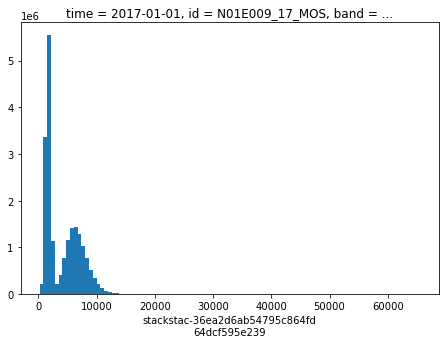

In [5]:
data.sel(band="HH").plot.hist(bins=100, size=5);

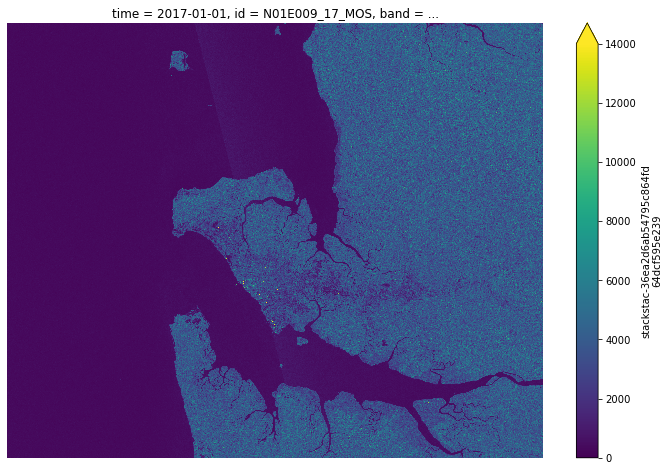

In [6]:
img = data.sel(band="HV").plot(vmin=0, vmax=14000, size=8)
img.axes.set_axis_off();

### Forest Classification

ALOS Forest/Non-Forest Classification is derived from the ALOS PALSAR Annual Mosaic, and classifies the pixels to detect forest cover. We'll search for Forest / Non-Forest items covering the same area.

In [7]:
import shapely.geometry

s = shapely.geometry.shape(item.geometry)
intersects = shapely.geometry.mapping(s.centroid)

search = client.search(collections=["alos-fnf-mosaic"], intersects=intersects)
fnf_items = search.get_all_items()
print(f"Returned {len(fnf_items)} items")

The primary asset is under the key `C`.

In [10]:
fnf_item = planetary_computer.sign(fnf_items[0])

fnf_tile = stackstac.stack(
    fnf_item, assets=["C"], dtype="uint8", fill_value=0
).squeeze()
fnf_tile

/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))


<xarray.DataArray 'stackstac-4a1854c8f5c3f9c4de06fb14dcc9603c' (y: 4500, x: 4500)>
dask.array<getitem, shape=(4500, 4500), dtype=uint8, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/18)
    time            datetime64[ns] 2017-01-01
    id              <U14 'N01E009_17_FNF'
    band            <U1 'C'
  * x               (x) float64 9.0 9.0 9.0 9.001 ... 9.999 9.999 10.0 10.0
  * y               (y) float64 1.0 0.9998 0.9996 ... 0.0004444 0.0002222
    title           <U1 'C'
    ...              ...
    description     <U32 'Forest/Non-Forest Classification'
    proj:shape      object {4500}
    start_datetime  <U20 '2017-01-01T00:00:00Z'
    platform        <U6 'ALOS-2'
    raster:bands    object {'nodata': 0, 'data_type': 'uint8'}
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(9.0, 0.0, 10.0, 1.0), resoluti...
    crs:         epsg:4326
    transform:   | 0.00, 0.00, 9.00|\n| 0.00,-0.00, 1.00|\n| 0.00, 0.00, 1.00|
    resolution:  0.00022222222222222223

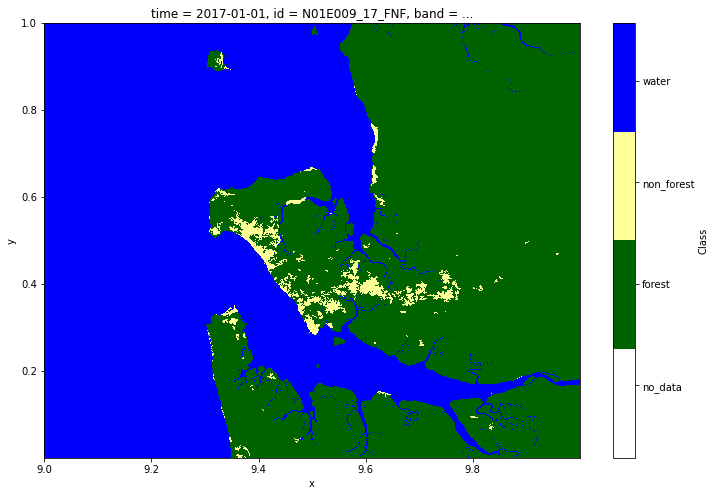

In [11]:
import matplotlib.colors

cmap = matplotlib.colors.ListedColormap(
    [
        (0, 0, 0, 0),  # nodata
        (0, 0.39, 0, 1),  # forest
        (1, 1, 0.6, 1),  # non-forest
        (0.0, 0.0, 1, 1),  # water
    ]
)
classes = fnf_item.get_collection().extra_fields["item_assets"]["C"][
    "classification:classes"
]
labels = [x["name"] for x in classes]

# Plot the classification map
p = fnf_tile.plot(cmap=cmap, vmin=0, vmax=3, size=8)
ticks = np.arange(0.5, 3, 0.7)
p.colorbar.set_ticks(ticks, labels=labels)
p.colorbar.set_label("Class")